In [ ]:
#Imports & Configuration

import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tqdm import tqdm

# --- CONFIGURATION ---
TFLITE_MODEL_PATH = Path("mobile_TEST.tflite")
IMAGE_FOLDER       = Path(r"C:\Users\arpitasharma2\OneDrive - Deloitte (O365D)\Desktop\DIU\SNAP\SNAP")
OUTPUT_CSV         = Path("tflite_predictions.csv")
IMAGE_SIZE         = (256, 256)       # must match model input
THRESHOLD          = 0.85             # recaptured probability threshold
CLASS_NAMES        = ["not_recaptured", "recaptured"]  # adjust if your labels differ


In [ ]:
#Load and initialize the TFLite interpreter

interpreter = tf.lite.Interpreter(model_path=str(TFLITE_MODEL_PATH))
interpreter.allocate_tensors()

# Get I/O tensor details for later
input_details  = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print("TFLite model loaded. Input shape:", input_details["shape"])

TFLite model loaded. Input shape: [  1   3 256 256]


In [ ]:
#Pre-processing & Inference Helpers (handles both NHWC/NCHW)

# Determine expected data format:
in_shape = input_details["shape"]
# if channels dim is second, it's NCHW; if last, NHWC
DATA_FORMAT = "NCHW" if in_shape[1] == 3 else "NHWC"
print("Using", DATA_FORMAT, "data format for TFLite input.")

def preprocess_image(img_path: Path) -> np.ndarray:
    """Load image, resize, normalize, batch-ify, and transpose if needed."""
    img = Image.open(img_path).convert("RGB")
    img = img.resize(IMAGE_SIZE, Image.BILINEAR)
    
    arr = np.array(img, dtype=np.float32) / 255.0
    # ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    arr = (arr - mean) / std
    
    # add batch dim -> (1, H, W, 3)
    arr = np.expand_dims(arr, axis=0)
    
    if DATA_FORMAT == "NCHW":
        # transpose to (1, 3, H, W)
        arr = np.transpose(arr, (0, 3, 1, 2))
    return arr

def predict_tflite(img_arr: np.ndarray) -> np.ndarray:
    """Run the interpreter and return raw logits."""
    interpreter.set_tensor(input_details["index"], img_arr.astype(input_details["dtype"]))
    interpreter.invoke()
    return interpreter.get_tensor(output_details["index"])

def softmax(logits: np.ndarray) -> np.ndarray:
    e = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)


Using NCHW data format for TFLite input.


In [ ]:
#Gather all image files

image_paths = []
for ext in ("*.jpg","*.jpeg","*.png"):
    image_paths.extend(IMAGE_FOLDER.glob(ext))
image_paths = sorted(image_paths)

print(f"Found {len(image_paths)} images in {IMAGE_FOLDER}")


Found 8532 images in C:\Users\arpitasharma2\OneDrive - Deloitte (O365D)\Desktop\DIU\SNAP\SNAP


In [ ]:
#Run predictions and collect results

records = []
for img_path in tqdm(image_paths, desc="Predicting"):
    try:
        arr    = preprocess_image(img_path)
        logits = predict_tflite(arr)
        probs  = softmax(logits)[0]           # Shape: (2,)
        
        recap_prob = float(probs[1])
        flag       = int(recap_prob >= THRESHOLD)
        pred_cls   = CLASS_NAMES[int(np.argmax(probs))]
        
        records.append({
            "Image": str(img_path),
            "Class": pred_cls,
            "Flag": flag,
            "Recaptured_Probability": recap_prob
        })
    except Exception as e:
        print(f"Error on {img_path.name}: {e}")


Predicting: 100%|██████████| 8532/8532 [03:55<00:00, 36.28it/s]


In [ ]:
#Save to CSV and display sample

df = pd.DataFrame(records)
df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved {len(df)} predictions to {OUTPUT_CSV}\n")
display(df.head(10))

Saved 8532 predictions to tflite_predictions.csv



,Image,Class,Flag,Recaptured_Probability
0,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.000004
1,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.000027
2,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.000002
3,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.000020
4,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.124099
5,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.000065
6,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.034404
7,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.000284
8,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.000072
9,C:\Users\arpitasharma2\OneDrive - Deloitte (O3...,not_recaptured,0,0.000034


In [21]:
#flag images 
import shutil
import os

# Define output folders
output_dir = Path(r"C:\Users\arpitasharma2\OneDrive - Deloitte (O365D)\Desktop\DIU\Classification\flagged_snap")
flag_0_dir = output_dir / "flag_0_A_tfllite"
flag_1_dir = output_dir / "flag_1_A_tflite"

# Create directories if they don't exist
flag_0_dir.mkdir(parents=True, exist_ok=True)
flag_1_dir.mkdir(parents=True, exist_ok=True)

# Copy images to respective folders
for _, row in df.iterrows():
    src = Path(row['Image'])
    dest_dir = flag_1_dir if row['Flag'] == 1 else flag_0_dir
    try:
        shutil.copy(src, dest_dir)
    except Exception as e:
        print(f" Could not copy {src.name} to {dest_dir}: {e}")

print(f"\n Images have been copied into respective folders:\yu8/>\"n- {flag_0_dir}\n- {flag_1_dir}")



 Images have been copied into respective folders:\yu8/>"n- C:\Users\arpitasharma2\OneDrive - Deloitte (O365D)\Desktop\DIU\Classification\flagged_snap\flag_0_A_tfllite
- C:\Users\arpitasharma2\OneDrive - Deloitte (O365D)\Desktop\DIU\Classification\flagged_snap\flag_1_A_tflite


In [ ]:
#Summary statistics
total = len(df)

# Recaptured vs Not
n_rec      = df["Class"].eq("recaptured").sum()
n_not_rec  = df["Class"].eq("not_recaptured").sum()
pct_rec    = n_rec/total * 100
pct_not    = n_not_rec/total * 100

# Within recaptured predictions, flag breakdown
rec_df     = df[df["Class"] == "recaptured"]
n_rec_flag1 = rec_df["Flag"].eq(1).sum()
n_rec_flag0 = rec_df["Flag"].eq(0).sum()
pct_rec_flag1_of_rec = n_rec_flag1 / len(rec_df) * 100 if len(rec_df) else 0
pct_rec_flag0_of_rec = n_rec_flag0 / len(rec_df) * 100 if len(rec_df) else 0

# Recaptured & flag by total
n_rec0_tot = ((df["Class"]=="recaptured") & (df["Flag"]==0)).sum()
n_rec1_tot = ((df["Class"]=="recaptured") & (df["Flag"]==1)).sum()
pct_rec0_tot = n_rec0_tot/total * 100
pct_rec1_tot = n_rec1_tot/total * 100

print(f"Total images: {total}\n")

print(f"Predicted recaptured:     {n_rec}  ({pct_rec:.2f}%)")
print(f"Predicted not_recaptured: {n_not_rec}  ({pct_not:.2f}%)\n")

print(f"Of all recaptured predictions:")
print(f"  • Flag 1 (prob ≥ threshold): {n_rec_flag1} ({pct_rec_flag1_of_rec:.2f}%)")
print(f"  • Flag 0 (prob <  threshold): {n_rec_flag0} ({pct_rec_flag0_of_rec:.2f}%)\n")

print(f"Of the entire dataset:")
print(f"  • Recaptured & Flag 1: {n_rec1_tot} ({pct_rec1_tot:.2f}%)")
print(f"  • Recaptured & Flag 0: {n_rec0_tot} ({pct_rec0_tot:.2f}%)")


Total images: 8532

Predicted recaptured:     52  (0.61%)
Predicted not_recaptured: 8480  (99.39%)

Of all recaptured predictions:
  • Flag 1 (prob ≥ threshold): 15 (28.85%)
  • Flag 0 (prob <  threshold): 37 (71.15%)

Of the entire dataset:
  • Recaptured & Flag 1: 15 (0.18%)
  • Recaptured & Flag 0: 37 (0.43%)


Unique true labels:      ['SNAP']
Unique predicted labels: ['not_recaptured', 'recaptured']
Using these labels for confusion matrix & report: ['SNAP', 'not_recaptured', 'recaptured']

Classification Report:

                precision    recall  f1-score   support

          SNAP       0.00      0.00      0.00    8532.0
not_recaptured       0.00      0.00      0.00       0.0
    recaptured       0.00      0.00      0.00       0.0

      accuracy                           0.00    8532.0
     macro avg       0.00      0.00      0.00    8532.0
  weighted avg       0.00      0.00      0.00    8532.0



c:\Users\arpitasharma2\AppData\Local\anaconda3\envs\tflite-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arpitasharma2\AppData\Local\anaconda3\envs\tflite-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arpitasharma2\AppData\Local\anaconda3\envs\tflite-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

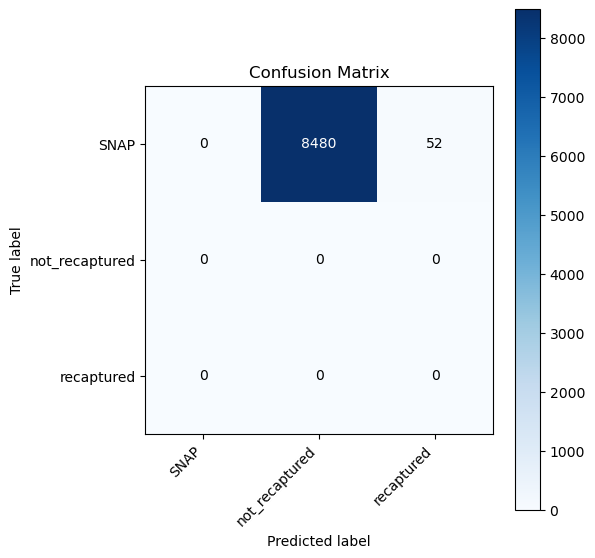

c:\Users\arpitasharma2\AppData\Local\anaconda3\envs\tflite-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arpitasharma2\AppData\Local\anaconda3\envs\tflite-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arpitasharma2\AppData\Local\anaconda3\envs\tflite-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

df["TrueLabel"] = df["Image"].apply(lambda s: Path(s).parent.name)

# --- Inspect what labels we actually have ---
unique_true = sorted(df["TrueLabel"].unique())
unique_pred = sorted(df["Class"].   unique())
print("Unique true labels:     ", unique_true)
print("Unique predicted labels:", unique_pred)

# --- Build label list for metrics ---
labels = sorted(set(unique_true) | set(unique_pred))
print("Using these labels for confusion matrix & report:", labels)

# --- Compute metrics ---
y_true = df["TrueLabel"].values
y_pred = df["Class"].     values
cm     = confusion_matrix(y_true, y_pred, labels=labels)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

# --- Plot confusion matrix ---
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels, yticklabels=labels,
    xlabel='Predicted label',
    ylabel='True label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

thresh = cm.max() / 2.0
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm[i,j], ha="center",
                va="center",
                color="white" if cm[i,j] > thresh else "black")

plt.tight_layout()
plt.show()

# --- (Optional) Save out the matrix/report ---
pd.DataFrame(cm, index=labels, columns=labels) \
  .to_csv("confusion_matrix.csv")
with open("classification_report.txt", "w") as f:
    f.write(classification_report(y_true, y_pred, labels=labels, target_names=labels))

In [ ]:
#Class‐level summary: counts + percentage
total = len(df)
counts = df["Class"].value_counts().reindex(CLASS_NAMES, fill_value=0)
percents = counts / total * 100

print(f"\nTotal images: {total}\n")
for cls in CLASS_NAMES:
    cnt = counts[cls]
    pct = percents[cls]
    print(f"{cls:15s}: {cnt:4d} images   ({pct:5.1f}%)")

# --- (then continue onto adding true labels, metrics, plotting, etc.) ---
df["TrueLabel"] = df["Image"].apply(lambda p: Path(p).parent.name)



Total images: 8532

not_recaptured : 8480 images   ( 99.4%)
recaptured     :   52 images   (  0.6%)
